In [ ]:
import os
import sys
import pandas as pd
from dotenv import load_dotenv
import re

project_root = os.path.abspath("..")
sys.path.append(project_root) 
load_dotenv(os.path.join(project_root, ".env"))
api_key = os.getenv("GENAI_API_KEY")
# api_key

from utils.utils import (
    VisionLanguageModel,
    DataUtils,
    prepare_content,
    get_answers_chunked,
    make_gold_file_json,
    visualize_image,
    get_answers,
)

In [2]:
vlm = VisionLanguageModel(api_key=api_key)

In [3]:
df = DataUtils.load_parquet("../eval_pqs/val.parquet")

Loaded DataFrame from ../eval_pqs/val.parquet, shape=(347, 11)


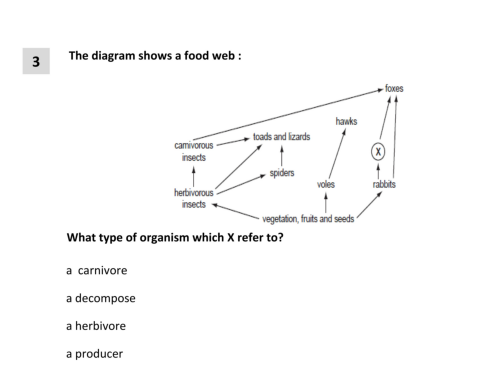

Predicted answer: The answer to the question is determined by the food web diagram. 'X' is pointing to the 'rabbits' Rabbits eat vegetation, fruits and seeds. Therefore, rabbits are herbivores.

C


In [12]:
row = df.iloc[1]
prompt, img = prepare_content(row, strict=True)
visualize_image(row["image"]["bytes"])

answer = vlm.get_answer(prompt, img, model="gemini-2.0-flash", strict=True, thinking=False)
print(f"Predicted answer: {answer}")

In [10]:
df.iloc[1]['answer_key']

'A'

In [13]:
answers, failures = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.0-flash",
    strict=True, 
    step=10,
    thinking=False,
)
print(f"Got {len(answers)} answers, failed on rows: {failures}")


DataUtils.save_to_json(answers, "../outputs/predictions.json")

Got 347 answers, failed on rows: []
Saved JSON to ../outputs/predictions.json


In [14]:
len(answers)

347

In [17]:
answers[0]

{'id': '1c6b887a-f86e-4982-acba-8438ec9a9878',
 'answer_key': 'Based on the diagram:\n- Vessel X is connected to the capillary network in the lungs, where oxygenation occurs. Thus, blood in X should be oxygenated.\n- Vessel Y is connected to the capillary network in body organs, where oxygen is used up. Thus, blood in Y should be deoxygenated.\n\nTherefore, the correct answer is:\nX oxygenated Y deoxygenated\n\nC',
 'language': 'English'}

In [23]:
for ans in answers:
    print(ans['id'], ans["answer_key"][-50:], end="\n\n")

1c6b887a-f86e-4982-acba-8438ec9a9878  correct answer is:
X oxygenated Y deoxygenated

C

b8761ea2-9fb7-4dd7-a39a-2bdf7d7218ca ats plants.
The correct answer is "a herbivore"

C

c08221f8-a879-4a44-a109-36d4fd8b6e3d zyme
II: presence of an enzyme

The answer is C

C

c5d80e71-416e-46d4-b242-182653d66e6e C

8dbfe100-a068-4bac-bc3f-19681f7cea82 C

60cd12cb-645a-474f-95d3-b51731d012b8 , 1 and 2 are part of AMP.
So, the answer is B.

B

530dd6e1-1bb9-407b-8ff0-493ca5b4ad92 ty to bicarbonate and hydrogen ions and ammonia

B

32aa2afc-f6d3-4a8d-8f44-97644bccbb67 ch names Cerebrum and its function is option A.

A

9beb8630-64c1-498b-9455-2b11594b6bd3 A

62ef4dc3-2c92-44d6-bbf0-9880b3d71635 n, which is the clumping of cells or particles.

C

96d1ee3d-9622-463d-9a5b-2ed52be21718 4
D

9628fff4-863b-4209-bb56-e3c531ee31b6 B

5800276e-e8fe-4913-aae0-699b9a222684 C

c8817919-ce2e-4221-ab0d-462167c4b26a A

623d7efe-8c9d-4628-946a-72ee5b8a4aac b and Bb
B. Bb and bb
C. BB and bb
D. BB and Bb

A

a54dd4

In [41]:
ans = [extract_answer(x[-5:]) for x in ans if x not in ['A', 'B', 'C', 'D', 'E']]

In [39]:
def extract_answer(raw: str) -> str:
    """
    Given a model output that ends with (or contains) the answer letter A–E,
    possibly wrapped in punctuation or markdown, return that letter.
    Returns an empty string if no valid answer is found.
    """
    # This looks for one of A–E, capturing it, followed only by non-letters/spaces to the end.
    m = re.search(r'([A-E])\W*$', raw.strip())
    return m.group(1) if m else ""

In [46]:
def postprocess_regex(answers):
    """
    Postprocesses the answers to extract the answer letter from the model output.
    """
    for ans in answers:
        ans["answer_key"] = extract_answer(ans["answer_key"][-5:])

In [47]:
postprocess_regex(answers)

In [49]:
DataUtils.save_to_json(answers, "../outputs/val-gemini-2-flash.json")

Saved JSON to ../outputs/val-gemini-2-flash.json


In [ ]:
# python evaluate.py --pred_file="./answers_2_flash.json" --gold_file="./gold_file.json" --print_score="True" 